## Hi
---
* Roll : ES20BTECH11015
* Requirements - Numpy, torch, PIL, tqdm (for progress bar ), opencv for (heatmaps in CAM)

In [272]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import imageio
import os
from tqdm import tqdm

In [273]:
# define your own loss function
def loss_function(x, y):
    return 10*x*x + y*y

### Let us implement the rules from scratch Now

The rules are all variations of finding the gradient of the function that is given, we can do that using 
a simple grad function.

In [274]:
x,y = 90, 95 # random starting point
x_mom,y_mom = 90, 95
x_adg ,y_adg = 90, 95
x_rms ,y_rms = 90, 95
x_adam ,y_adam = 90, 95
v_x = 0
v_y = 0
adam_v_x = 0
adam_v_y = 0
NUM_EPOCH = 1000
rms_v_x = 0
rms_v_y = 0
adg_v_x = 0
adg_v_y = 0
adam_m_x = 0
adam_m_y = 0
MOMENTUM = 0.9

In [275]:
def get_gradient(x, y):
    return 20*x, 2*y

In [276]:
def step_SGD(x, y, learning_rate): # no accumulation
    x_grad, y_grad = get_gradient(x, y)
    x = x - learning_rate*x_grad
    y = y - learning_rate*y_grad
    return x, y

In [277]:
def step_momentum(x, y, learning_rate, momentum):
    global v_x, v_y
    x_grad, y_grad = get_gradient(x, y) # leaking first order gradient
    v_x = momentum*v_x + x_grad
    v_y = momentum*v_y + y_grad
    x_new = x - learning_rate*v_x
    y_new = y - learning_rate*v_y
    return x_new, y_new

In [278]:
def step_adagrad(x, y, learning_rate, epsilon=1e-8): # non leaky accumulation of second order gradient, stops movement, so need a higher learning rate
    global adg_v_x, adg_v_y
    x_grad, y_grad = get_gradient(x, y)
    adg_v_x = adg_v_x + x_grad**2
    adg_v_y = adg_v_y + y_grad**2
    x_new = x - learning_rate*x_grad/(np.sqrt(adg_v_x) + epsilon)
    y_new = y - learning_rate*y_grad/(np.sqrt(adg_v_y) + epsilon)
    return x_new, y_new

In [279]:
def step_rmsprop(x, y, learning_rate, decay_rate=0.99999, epsilon=1e-8): # leaky accumulation of second order gradient
    global rms_v_x, rms_v_y
    x_grad, y_grad = get_gradient(x, y)
    rms_v_x = decay_rate*rms_v_x + (1-decay_rate)*x_grad**2
    rms_v_y = decay_rate*rms_v_y + (1-decay_rate)*y_grad**2
    x_new = x - learning_rate*x_grad/(np.sqrt(rms_v_x) + epsilon)
    y_new = y - learning_rate*y_grad/(np.sqrt(rms_v_y) + epsilon)
    return x_new, y_new

In [285]:
# Leaky accumulation of first and second order gradient
def step_adam(x, y, learning_rate, beta1=0.9, beta2=0.9999999, epsilon=1e-8): 
    global adam_v_x, adam_v_y, adam_m_x, adam_m_y
    x_grad, y_grad = get_gradient(x, y)
    adam_m_x = beta1*adam_m_x + (1-beta1)*x_grad
    adam_m_y = beta1*adam_m_y + (1-beta1)*y_grad
    adam_v_x = beta2*adam_v_x + (1-beta2)*x_grad**2
    adam_v_y = beta2*adam_v_y + (1-beta2)*y_grad**2
    x_new = x - learning_rate*adam_m_x/(np.sqrt(adam_v_x) + epsilon)
    y_new = y - learning_rate*adam_m_y/(np.sqrt(adam_v_y) + epsilon)
    return x_new, y_new

Text(0.5, 1.0, 'Contour of the loss function')

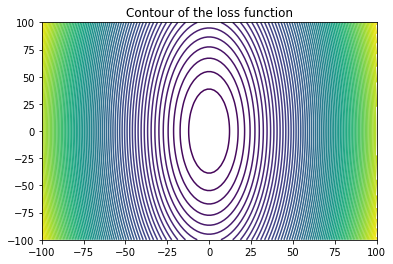

In [281]:
x1 = np.linspace(-100, 100, 100)
x2 = np.linspace(-100, 100, 100)
X1, X2 = np.meshgrid(x1, x2)
Z = 10*X1*X1 + X2*X2
plt.contour(X1, X2, Z, 100)
plt.title('Contour of the loss function')

100%|██████████| 199/199 [00:18<00:00, 10.57it/s]


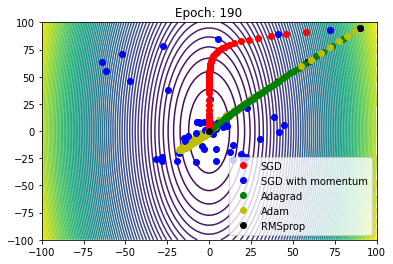

In [282]:
x1 = np.linspace(-100, 100, 100)
x2 = np.linspace(-100, 100, 100)
X1, X2 = np.meshgrid(x1, x2)
Z = 10*X1*X1 + X2*X2
plt.contour(X1, X2, Z, 100)
filenames = []
for epoch in tqdm(range(1,200)):
    loss = loss_function(x, y)
    if(epoch%10==0 or epoch < 50):
        plt.plot([x], [y], 'ro')
        plt.plot([x_mom], [y_mom], 'bo')
        plt.plot([x_adg], [y_adg], 'go')
        plt.plot([x_adam], [y_adam], 'yo')
        plt.plot([x_rms], [y_rms], 'ko')
        filenames.append('Figures/orig_frame{:03d}.png'.format(epoch))
        plt.legend(['SGD', 'SGD with momentum', 'Adagrad', 'Adam', 'RMSprop'])
        plt.title('Epoch: {}'.format(epoch))
        plt.savefig(filenames[-1])
    x,y = step_SGD(x, y, 0.01)
    x_mom,y_mom = step_momentum(x_mom, y_mom, 0.01, MOMENTUM)
    x_adg,y_adg = step_adagrad(x_adg, y_adg, 10)
    x_rms,y_rms = step_rmsprop(x_rms, y_rms, 0.1)
    x_adam,y_adam = step_adam(x_adam, y_adam, 0.01)

In [283]:
with imageio.get_writer('optim.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.v2.imread(filename)
        writer.append_data(image)

In [284]:
for file in filenames:
    os.remove(file)

![Plot](optim.gif)
